Los objetivos de este notebook son:
- Ilustrar como crear un `Dataset` de PyTorch que permita obtener batches de datos basados en una serie de tiempo, dada una ventana histórica predictiva y una ventana futura a predecir.
- Ilustrar el manejo del módulo `nn.RNN` de PyTorch para crear capas de neuronas recurrentes sencillas.
- Aplicar lo aprendido a un proceso de pronóstico de una serie de tiempo de la función seno.

Este notebook está basado en material encontrado en:
- *Machine Learning with PyTorch and Scikit-Learn*, Sebastian Raschka, Yuxi Liu & Vahid Mirjalili, Packt, 2022
- *Dive into Deep Learning*, Aston Zhang, Zachary C. Lipton, Mu Li & Alexander J. Smola, https://d2l.ai/, 2022
- *PyTorch*, https://pytorch.org/

# 1. Establecimiento del ambiente de desarrollo y ejecución.

Preparamos el ambiente de desarrollo y ejecución, cargando librerías, verificando el dispositivo disponible (CPU o CUDA), y reseteando el seed.

In [1]:
import numpy as np
import pandas as pd
import os, random, math, time
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

Utilizamos la primera GPU disponible


device(type='cuda', index=0)

In [3]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [4]:
sns.set_style('whitegrid')

# 2. Datos sintéticos de estudio

Vamos a crear un dataset sencillo con la función sinusoidal, utilizando:
- `torch.linspace` : que permite obtener un tensor con una secuencia de valores ordenados y separados entre ellos equidistantemente. Recibe como parámetros el primer, último elemento de la secuencia (no incluido), y el número de puntos a generar.
- `torch.rand`: que permite generar valores aleatorios usando una distribución uniforme.
- `torch.randn`: que permite generar valores aleatorios usando una distribución normal, teniendo como valores por defecto de sus parámetros media 0 y stdev 1, para utilizar por defecto una distribución normal estándar
- `torch.sin`: que recibe un tensor de valores en radianes y retorna un tensor con la función *seno* aplicada a los mismos.

In [5]:
radMin = -30 # comienzo de la secuencia de los inputs (x) en radianes
radMax = 30 # final de la secuencia de los inputs (x) en radianes
numPuntos = 3000
nivel_ruido_x = 0.5 # nivel de ruido agregado a los inputs (x)
nivel_ruido_y = 0.2 # nivel de ruido agregado a las salidas (y)

Vamos a generar datos aleatorios equidistantes que servirán como inputs, a los que agregaremos un ruido uniforme para eliminar la equidistancia. Veamos el resultado de aplicar la función seno a estos valores.

In [6]:
reset_seed()
torch.linspace(radMin, radMax, numPuntos)

tensor([-30.0000, -29.9800, -29.9600,  ...,  29.9600,  29.9800,  30.0000])

In [7]:
torch.rand(numPuntos)[:10]

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408,
        0.1332])

In [8]:
torch.linspace(radMin, radMax, numPuntos) + nivel_ruido_x*torch.rand(numPuntos)

tensor([-29.5575, -29.5426, -29.6247,  ...,  29.9783,  30.0210,  30.0006])

Text(0, 0.5, 'Y')

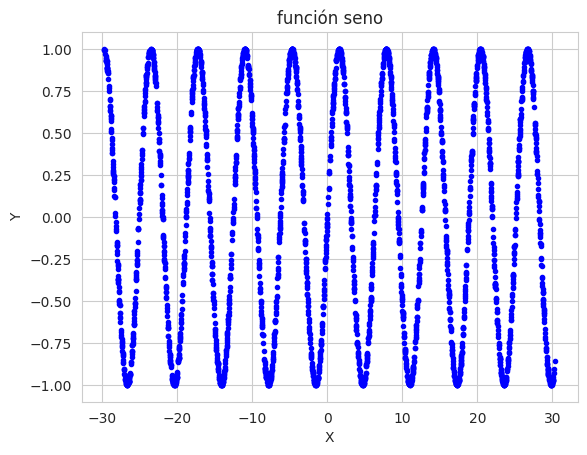

In [9]:
reset_seed()
x = torch.linspace(radMin, radMax, numPuntos) + nivel_ruido_x*torch.rand(numPuntos)
torch.sort(x)
y = torch.sin(x)

# Plotting
plt.scatter(x.numpy(), y.numpy(), color = 'blue', marker = ".")
plt.title("función seno")
plt.xlabel("X")
plt.ylabel("Y")

Vamos ahora a simular ruido en los datos de salida.

Text(0, 0.5, 'Y')

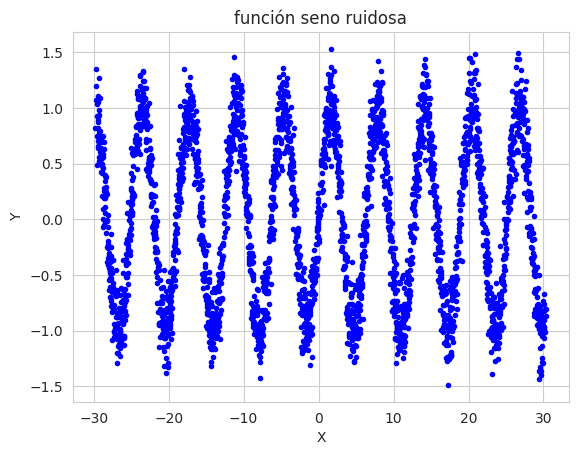

In [10]:
reset_seed()
ruido_y = torch.randn(numPuntos)
y = torch.sin(x) + nivel_ruido_y*torch.randn(numPuntos)

# Plotting
plt.scatter(x.numpy(), y.numpy(), color = 'blue', marker = ".")
plt.title("función seno ruidosa")
plt.xlabel("X")
plt.ylabel("Y")

Vamos a crear ahora una clase que represente el proceso generador de este dataset a partir de la clase `Dataset` de PyTorch. Necesitamos definir entonces:
- La clase  `SerieTiempoSenoDataset`, que hereda de `Dataset`
- El método `__init__` que se ejecuta al crear una instancia del dataset, en la que inicializamos los atributos del dataset, en este caso:
    - `numPuntos`: número de puntos a generar. Por defecto es 3000. Se le agregará el tamaño de la ventana histórica.
    - `ventanaPasado`: número de pasos de tiempo históricos a considerar como predictores. Por defecto es 20.
    - `ventanaFuturo`: número de pasos de tiempo futuros a predecir. Por defecto es 1.
    - `radMin`: número de radianes mínimo. Por defecto es -6.
    - `radMax`: número de radianes mínimo. Por defecto es 6.
    - `nivelRuidoX`: multiplicador que agrega ruido en la separación de los valores generados de la variable independiente. Por defecto es 0.5. El ruido se genera según una distribución uniforme en el intervalo [0, 1].
    - `nivelRuidoY`: multiplicador que agrega ruido en la variable dependiente resultante de la aplicación del seno (el valor final no va a estar necesariamente entre -1 y 1). Por defecto es 0.2. El ruido se genera según una distribución normal estándar.
    - `seed`: semilla aleatoria para generar los puntos. Por defecto es 42.
- El método `__len__` que retorna el número de elementos del dataset.
- El método `__get_item__` que retorna una instancia del dataset, una tupla que incluye la ventana de tiempo pasado de datos y la ventana de tiempo futura a predecir, dado un índice específico que recibe como parámetro de entrada. Vale la pena anotar que los valores de la variable independiente $x$ usada para generar los valores del seno no son parte de los datos que se retornan, solo la secuencia de valores resultantes de $sin(x)$.

In [11]:
class SerieTiempoSenoDataset(Dataset):
    def __init__(self, numPuntos=3000, ventanaPasado=20, ventanaFuturo=1, numRadMin=-6, numRadMax=6, nivelRuidoX=0.5, nivelRuidoY=0.2, seed=42):
        self.seed = seed
        self.numPuntos = numPuntos
        self.ventanaPasado = ventanaPasado
        self.ventanaFuturo = ventanaFuturo
        self.numRadMin = numRadMin
        self.numRadMax = numRadMax
        self.nivelRuidoX = nivelRuidoX
        self.nivelRuidoY = nivelRuidoY
        reset_seed()
        # Generamos puntos aleatorios en el intervalo de radianes dado,
        # al número de puntos generados se debe ademas agregar el tamaño de las
        # ventanas. Agregamos ruido siguiendo distribución uniforme entre 0 y 1
        ruidoX = nivelRuidoX*torch.rand(numPuntos+ventanaPasado+ventanaFuturo-1)
        self.x = torch.linspace(numRadMin, numRadMax, numPuntos+ventanaPasado+ventanaFuturo-1) + ruidoX
        # Ordenamos los puntos, pues el ruido puede haber influido en la
        # secuencialidad de los puntos
        torch.sort(self.x)
        # Obtenemos los senos de los puntos, y agregamos el ruido (normal estándar)
        ruidoY = self.nivelRuidoY*torch.randn(numPuntos+ventanaPasado+ventanaFuturo-1)
        self.y = torch.sin(self.x) + ruidoY

    def __len__(self):
        return self.numPuntos

    def __getitem__(self, idx):
        if (idx >= self.numPuntos) or (idx < 0):
            raise Exception("Out of bounds: idx=", idx)
        return torch.reshape(self.y[idx: idx+self.ventanaPasado], (self.ventanaPasado, 1)),\
            self.y[idx+self.ventanaPasado: idx+self.ventanaPasado+self.ventanaFuturo]

Ahora que creamos el dataset, vamos a instanciarlo para obtener datos de *training* y de *test*.

In [12]:
train_data = SerieTiempoSenoDataset(numPuntos=200, ventanaPasado=10, ventanaFuturo=1, numRadMin=-10, numRadMax=10)
val_data = SerieTiempoSenoDataset(numPuntos=200, ventanaPasado=10, ventanaFuturo=1, numRadMin=10, numRadMax=20)

Veamos como se ven las series de puntos generados.

Text(0, 0.5, 'Y')

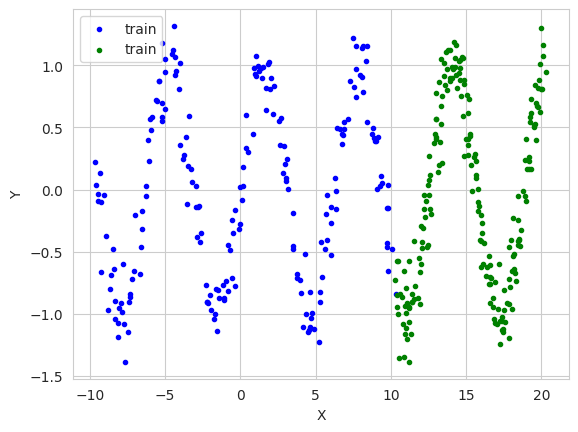

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(train_data.x, train_data.y, color = 'blue', marker = ".", label='train')
ax1.scatter(val_data.x, val_data.y, color = 'green', marker = ".", label='train')
plt.legend(loc='upper left')
plt.xlabel("X")
plt.ylabel("Y")

El dataset tiene entonces duplas de ventanas de predictores y valores a predecir. La idea es predecir un valor futuro dados los diez valores anteriores. Por ejemplo, veamos la primera dupla de datos generados con los primeros elementos de la serie.

In [14]:
train_data[0]

(tensor([[ 0.0347],
         [-0.0964],
         [ 0.2221],
         [-0.1022],
         [-0.0324],
         [-0.6660],
         [ 0.1338],
         [-0.3743],
         [-0.9699],
         [-0.0437]]),
 tensor([-0.6887]))

Vemos entonces lo que sería la ventana histórica de inputs (una secuencia de 10 valores), con la secuencia de valores a predecir en la ventana futura (una secuencia de un único valor en este caso).

Es importante notar que cada paso de tiempo en la ventana tiene un solo valor, ya que es una serie mono variable. Podríamos crear tambien series multivariables.

La podemos comparar con los primeros datos de la serie del dataset, incluyendo el(los) valor(es) futuro(s).

In [15]:
train_data.y[:train_data.ventanaPasado+train_data.ventanaFuturo]

tensor([ 0.0347, -0.0964,  0.2221, -0.1022, -0.0324, -0.6660,  0.1338, -0.3743,
        -0.9699, -0.0437, -0.6887])

In [16]:
train_data[0]

(tensor([[ 0.0347],
         [-0.0964],
         [ 0.2221],
         [-0.1022],
         [-0.0324],
         [-0.6660],
         [ 0.1338],
         [-0.3743],
         [-0.9699],
         [-0.0437]]),
 tensor([-0.6887]))

Ahora veamos la última dupla de datos generados con los últimos elementos de la serie.

In [17]:
train_data.y[-train_data.ventanaPasado-1:]

tensor([ 0.1088,  0.4257,  0.0547, -0.1508, -0.4667, -0.4311, -0.1495,  0.0323,
        -0.6581, -0.4804, -0.8395])

In [18]:
train_data[train_data.numPuntos-1]

(tensor([[ 0.1088],
         [ 0.4257],
         [ 0.0547],
         [-0.1508],
         [-0.4667],
         [-0.4311],
         [-0.1495],
         [ 0.0323],
         [-0.6581],
         [-0.4804]]),
 tensor([-0.8395]))

Ya que tenemos el dataset creado, vamos ahora a crear un `DataLoader` para poder obtener batches de entrenamiento y validación de cualquier modelo que vayamos a implementar.
El `DataLoader` de entrenamiento lo barajamos con `shuffle=True`, para no introducir sesgos de orden de presentación de instancias de aprendizale; el de test no requiere de ese tratamiento.

In [19]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)

Analicemos como sería la creación de un batch con los `DataLoader`.

In [20]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Train: Feature batch shape: {train_features.size()}")
print(f"Train: Labels batch shape: {train_labels.size()}")
val_features, val_labels = next(iter(val_dataloader))
print(f"Test: Feature batch shape: {val_features.size()}")
print(f"Test: Labels batch shape: {val_labels.size()}")

Train: Feature batch shape: torch.Size([32, 10, 1])
Train: Labels batch shape: torch.Size([32, 1])
Test: Feature batch shape: torch.Size([64, 10, 1])
Test: Labels batch shape: torch.Size([64, 1])


In [21]:
train_features[0]

tensor([[0.8995],
        [0.9842],
        [0.6420],
        [0.8177],
        [1.0309],
        [1.0142],
        [0.8136],
        [0.8965],
        [0.8326],
        [0.6111]])

In [22]:
train_labels[0]

tensor([0.5770])

Tenemos batches de 32 instancias; cada instancia de features tiene una ventana de tiempo (secuencia) con 10 valores consecutivos, y un label asociado con 1 solo valor de paso de tiempo futuro, tanto para training como para test.

# 3. Módulo RNN de PyTorch

Vamos ahora a ilustrar como crear un modelo RNN simple, utilizando la clase `torch.nn.RNN`, que crea una un módulo con capas recurrentes apiladas, recibiendo como parámetros:
- `input_size`: el número de **variables de entrada** de la capa inicial. A no confundir con el tamaño de la secuencia, hablamos aquí de los *features*, por ejemplo, la temperatura, la presión atmosférica, la cantidad de precipitación.
- `hidden_size`: el número de **neuronas recurrentes** de cada capa apilada.
- `num_layers`: el número de **capas recurrentes** a apilar. Si tenemos mas de una capa, las capas subsiguientes reciben como entrada los outputs de las capas anteriores. Sabemos que no es una buena decisión arquitectural tener muchas capas recurrentes.
- `nonlinearity`: la **función de activación** a utilizar para calcular los estados escondidos $h_t$. Por defecto es `'tanh'`
- `batch_first`: Si es `True`, los tensores de entrada y de salida presentan los ejes en este orden **(batch_size, timesteps, input_features)** en vez de **(timesteps, batch_size, input_features)**. Esto no aplica para los estados intermedios, solo para entradas y salidas. Por defecto es `False`.
- `dropout`: si diferente de 0, probabilidad utilizada por capas de `Dropout` intermedias entre las capas recurrentes. Por defecto es 0.

Importante notar que el largo de las secuencias a tratar por las capas `RNN` no tiene ninguna incidencia en la arquitectura de de las mismas (ni en el número de parámetros).

Creamos un modelo sencillo de una sola capa recurrente con 2 neuronas, que recibe 5 features de entrada, y que recibe los batches de instancias en el primer eje del tensor.

In [23]:
reset_seed()
rnn = nn.RNN(input_size=5, hidden_size=2, num_layers=1, batch_first=True)

El módulo `RNN` calcula el estado para cada capa a partir de la función de activación:
$$h_t = tanh({x_t​}W_{ih}^{T}+b_{ih}+{h_{t-1}​}W_{hh}^{T}+b_{hh})$$

Internamente se manejan 4 estructuras de parámetros por capa. Si tenemos una única capa (capa `'l0'`), tendremos:
- `weight_ih_l0`: matriz de pesos $W_{ih}$ que modifica los inputs para obtener los nuevos estados de las neuronas escondidas. Tiene como ejes `[hidden_size, input_size]`.
- `weight_hh_l0`: matriz de pesos $W_{hh}$ que modifica los estados anteriores para obtener los nuevos estados de las neuronas escondidas. Tiene como ejes `[hidden_size, hidden_size]`.
- `bias_ih_l0`: sesgo $b_{ih}$ para ajustar la combinación lineal de los inputs
- `bias_ih_l0`: sesgo $b_{hh}$ para ajustar la combinación lineal de los estados anteriores.

Vale la pena anotar que en esta implementación tenemos 2 sesgos independientes $b_{ih}$ y $b_{hh}$, pero como se suman antes de llamar a la función de activación se pueden considerar como un único sesgo $b_{h}$.

A todos los pesos se les aplica la inicialización de Xavier, con valores aleatorios siguiendo una distribución uniforme definida en el intervalo  $[-\sqrt\frac{1}{hidden\_size}, +\sqrt\frac{1}{hidden\_size}]$


Veamos los parámetros creados internamente por el modelo.

In [24]:
_=[print(param_name) for param_name in rnn.named_parameters()]

('weight_ih_l0', Parameter containing:
tensor([[ 0.5406,  0.5869, -0.1657,  0.6496, -0.1549],
        [ 0.1427, -0.3443,  0.4153,  0.6233, -0.5188]], requires_grad=True))
('weight_hh_l0', Parameter containing:
tensor([[0.6146, 0.1323],
        [0.5224, 0.0958]], requires_grad=True))
('bias_ih_l0', Parameter containing:
tensor([ 0.3410, -0.0998], requires_grad=True))
('bias_hh_l0', Parameter containing:
tensor([0.5451, 0.1045], requires_grad=True))


In [25]:
print('weight_ih_l0:', rnn.weight_ih_l0.shape)
print('weight_hh_l0:', rnn.weight_hh_l0.shape)
print('bias_ih_l0:', rnn.bias_ih_l0.shape)
print('bias_hh_l0:', rnn.bias_hh_l0.shape)

weight_ih_l0: torch.Size([2, 5])
weight_hh_l0: torch.Size([2, 2])
bias_ih_l0: torch.Size([2])
bias_hh_l0: torch.Size([2])


Vamos a crear un tensor de entrada para analizar su proceso a traves de la capa `RNN`.

Para ilustrar, vamos a tener un batch de entrada con una única instancia, con secuencias de 3 pasos de tiempo para 5 features. Cada instancia tendra un tensor organizado así: (timesteps=3, input_features=5).


In [26]:
x_seq = torch.tensor([[1.0]*5, [2.0]*5, [3.0]*5]).float()
print(x_seq.shape)
print(x_seq)

torch.Size([3, 5])
tensor([[1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3.]])


El modulo `RNN` espera un **tensor de entrada** cuyos ejes se organizan en el orden **(batch_size, timesteps, input_features)**, por lo que es necesario agregar el eje externo del batch con la única instancia.

In [27]:
print(torch.reshape(x_seq, (1, 3, 5)))

tensor([[[1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2.],
         [3., 3., 3., 3., 3.]]])


El llamado al módulo va a retornar dos tensores:
- un tensor de **outputs** con todos los estados de salida de las neuronas de la última capa recurrente (en este ejemplo una única capa), para todos los pasos de tiempo de la secuencia, cuyos ejes se organizan en  **(batch_size, timesteps, output_features)**.
- un tensor con los **estados** de salida del último paso para las neuronas de la última capa recurrente, cuyos ejes se organizan en  **(num_layers, batch_size, output_features)**. Estos están considerados en el tensor de **outputs**.

En cuanto a la salida del modelo, tendremos un valor por cada paso de tiempo de la secuencia, por cada una de las 2 neuronas de la última (en este caso única) capa del módulo recurrente.
Vamos ahora a enviar el tensor de prueba por el modelo para verificar su salida. Adicionalmente también habríamos podido enviar en el llamado un tensor con los estados iniciales $h_0$ a considerar para todas las capas del módulo `RNN`, pero al no enviarlo, estima un tensor con ceros por defecto.

In [28]:
output, hn = rnn(torch.reshape(x_seq, (1, 3, 5)))
print("output:", output.shape, "\n  ",output)
print("hn:", hn.shape, "\n  ", hn)

output: torch.Size([1, 3, 2]) 
   tensor([[[0.9817, 0.3122],
         [0.9997, 0.8287],
         [1.0000, 0.9156]]], grad_fn=<TransposeBackward1>)
hn: torch.Size([1, 1, 2]) 
   tensor([[[1.0000, 0.9156]]], grad_fn=<StackBackward0>)


Es importante notar que **todos los pasos de tiempo se procesan uno después de otro en el módulo `RNN` antes de producir las salidas**.
Vemos que los outputs tienen el valor de salida para cada neurona de la capa escondida para cada paso de tiempo. Las salidas del último paso de tiempo corresponde con el último estado de las neuronas escondidas.

Expliquemos ahora como se calcula el **feed forward** del modelo internamente. Vamos a tomar cada paso de tiempo a la vez, y crear la matriz con sus datos. Por ejemplo para el primer paso de tiempo tendremos:

In [29]:
print(x_seq[0])
print(torch.reshape(x_seq[0], (1, 5)))

tensor([1., 1., 1., 1., 1.])
tensor([[1., 1., 1., 1., 1.]])


In [30]:
out_man = [] # Aquí quedarán los estados temporales por cada paso de tiempo

# Recorremos los valores de los features por cada paso de tiempo
for t in range(3):
    # Preparamos los datos del paso de tiempo
    xt = torch.reshape(x_seq[t], (1, 5))
    print(f'Time step {t} =>')
    print(' Input :', xt.numpy())

    # Obtenemos el net input de las entradas z = X*W + b
    z_ih_t = torch.matmul(xt, torch.transpose(rnn.weight_ih_l0, 0, 1)) + \
        rnn.bias_ih_l0
    print(' Zs inputs :', z_ih_t.detach().numpy())

    # Obtenemos el net input del estado anterior
    if t > 0:
        prev_h = out_man[t-1]
    else: # primer paso, se parte de estados en 0
        prev_h = torch.zeros((z_ih_t.shape))

    # Calculamos el net input recurrente
    z_hh_t = torch.matmul(prev_h, torch.transpose(rnn.weight_hh_l0, 0, 1)) + \
        rnn.bias_hh_l0
    print(' Zs recurrentes :', z_hh_t.detach().numpy())

    # Calculamos el nuevo estado de salida
    o_t = torch.tanh(z_ih_t + z_hh_t)
    out_man.append(o_t)
    print(' Output (manual) :', o_t.detach().numpy())
    print(' RNN output :', output[:, t].detach().numpy())
    print()

Time step 0 =>
 Input : [[1. 1. 1. 1. 1.]]
 Zs inputs : [[1.797444   0.21845508]]
 Zs recurrentes : [[0.5450986  0.10451668]]
 Output (manual) : [[0.981705   0.31219152]]
 RNN output : [[0.981705  0.3121915]]

Time step 1 =>
 Input : [[2. 2. 2. 2. 2.]]
 Zs inputs : [[3.2539296 0.5367473]]
 Zs recurrentes : [[1.1897846 0.6472725]]
 Output (manual) : [[0.9997238  0.82871497]]
 RNN output : [[0.9997238 0.8287149]]

Time step 2 =>
 Input : [[3. 3. 3. 3. 3.]]
 Zs inputs : [[4.7104154 0.8550393]]
 Zs recurrentes : [[1.2692168 0.7061501]]
 Output (manual) : [[0.9999872  0.91561294]]
 RNN output : [[0.9999872 0.915613 ]]



# 4. Modelo de forecasting con RNN

Vamos a crear un modelo sencillo que nos permita realizar forecasting. Estará compuesto de un módulo recurrente `nn.RNN` y de una capa densa `nn.Linear` de salida (sin función de activación).
El modelo recibirá los siguientes hiper parámetros:
- `input_dim`: número de *features* predictivos.
- `hidden_dim`: número de neuronas escondidas en las capas del submódulo recurrente.
- `layer_dim`: número de capas en el submódulo recurrente.
- `output_dim`: número de neuronas de salida de la capa densa final.

La capa `nn.Linear` final deberá recibir sólo los estados escondidos de salida  del último paso de tiempo, por lo que se deberán desechar los anteriores.

Notar de nuevo, que el largo de las secuencias no tienen incidencia en la arquitectura del modelo.


In [31]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim

        # Módulo recurrente
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')

        # capa de salida
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Definimos los estados iniciales a considerar en lo módulo recurrente,
        # con un tensor de la forma (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.detach().to(DEVICE)

        # Procesamos los datos del batch a través del módulo recurrente
        out, hn = self.rnn(x, h0)

        # El tensor "out" tiene sus ejes (batch_size, timesteps, output_features)
        # con los estados escondidos de todos los pasos de tiempo. La capa
        # densa final, solo recibirá el último paso de tiempo.
        out = self.fc(out[:, -1, :])
        return out


Importante recalcar que :
- Cada instancia tratada por la red es una secuencia con varios pasos de tiempo
- Para cada instancia, se llama una única vez a la capa recurrente, enviándole toda la secuencia. Internamente, dentro de cada celda, se itera por cada paso de tiempo antes de producir la secuencia de salida para ser comunicada a la siguiente capa.
- Al comenzar el procesamiento de cada secuencia en una celula recurrente, los estados escondidos siempre se reinicializan, de tal manera que los calculos son independientes de las secuencias anteriores.

Vamos a instanciar el modelo para tratar los datos de forecasting de la función del seno del dataset previamente creados:
- Se tiene un solo feature de entrada (serie de tiempo univariada)
- Consideramos una única capa recurrente
- La capa recurrente consta de 10 neuronas (no nay relación con el largo de la secuencia)
- Solo vamos a tener un único output con el valor de la serie a predecir.

In [32]:
num_features = 1
num_hidden_neurons_per_layer = 10
num_layers = 1
num_outputs = 1
modelo_forecasting = RNNModel(
    input_dim=num_features,
    hidden_dim=num_hidden_neurons_per_layer,
    layer_dim=num_layers,
    output_dim=num_outputs)

modelo_forecasting = modelo_forecasting.to(DEVICE)

In [33]:
modelo_forecasting

RNNModel(
  (rnn): RNN(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
_=[print(param[0], ": ", param[1].shape) for param in modelo_forecasting.named_parameters()]

rnn.weight_ih_l0 :  torch.Size([10, 1])
rnn.weight_hh_l0 :  torch.Size([10, 10])
rnn.bias_ih_l0 :  torch.Size([10])
rnn.bias_hh_l0 :  torch.Size([10])
fc.weight :  torch.Size([1, 10])
fc.bias :  torch.Size([1])


Recordemos que el modelo tiene como primera capa de entrada una `RNN`, que espera un tensor de entrada con sus ejes organizados así: **(batch_size, timesteps, input_features)**, que concuerda con lo que produce el data loader.

In [35]:
train_features.shape

torch.Size([32, 10, 1])

Pasemos este batch por inferencia del modelo.

In [36]:
salida = modelo_forecasting(train_features.to(DEVICE))
print("salida:\n ", salida.shape, "\n ", salida)

salida:
  torch.Size([32, 1]) 
  tensor([[0.2091],
        [0.2698],
        [0.3202],
        [0.1759],
        [0.3480],
        [0.3560],
        [0.3319],
        [0.1642],
        [0.2034],
        [0.2941],
        [0.1449],
        [0.3613],
        [0.2150],
        [0.3041],
        [0.3008],
        [0.3187],
        [0.3157],
        [0.2083],
        [0.2173],
        [0.1590],
        [0.2528],
        [0.2339],
        [0.2716],
        [0.3347],
        [0.2205],
        [0.2843],
        [0.2975],
        [0.2974],
        [0.3144],
        [0.3269],
        [0.2543],
        [0.1729]], device='cuda:0', grad_fn=<AddmmBackward0>)


Vemos que por cada secuencia del batch, el modelo produce un valor de salida.
En este momento, es un modelo aleatorio, pues no se ha entrenado el modelo.

Vamos a definir varias funciones:
- una función con el proceso de entrenamiento del modelo.
- una función para plotear la evolución del loss a medida que avanzan las épocas de entrenamiento.
- una función que reciba un dataset de series de tiempo y retorne los pronósticos correspondientes a cada instancia.
- una función para plotear los valores reales vs los predichos por el modelo.

In [37]:
def train_model_forecasting(modelo, train_dataset, val_dataset, batch_size=32, learning_rate = 1e-3, epocas=30, verbose=False):
    """Se encarga de realizar el ciclo de épocas de entrenamiento de un modelo de forecasting.

    :modelo:
        instancia creada del modelo a entrenar
    :train_dataset:
        instancia de Dataset con los datos de entrenamiento
    :train_dataset:
        instancia de Dataset con los datos de validación
    :batch_size:
        tamaño del batch size de entrenamiento
    :learning_rate:
        learning rate del optimizador.
    :epocas:
        número de iteraciones de entrenamiento sobre el dataset completo
    :verbose:
        indica si se quiere imprimr el avance del proceso o no
    :returns:
        el modelo entrenado y 4 arrays con los valores de losses y accuracies del training dataset, y los losses del val set después de cada época
    """

    reset_seed()

    # Gestión de los loaders de training y validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Se crea el modelo y optimizador
    modelo = modelo.to(DEVICE) # situar el modelo en el dispositivo de procesamiento
    loss_fn = nn.MSELoss() # se usa una función de pérdida de regresión
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)

    # Creamos vectores donde almacenaremos los losses y métricas después de cada época
    train_losses = [0] * epocas
    val_losses = [0] * epocas

    for epoca in range(epocas):
        epoca_start_time = time.time()
        modelo.train()
        for batch_features, batch_labels in train_loader:
            # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)
            # Generar las predicciones de training
            batch_preds = modelo(batch_features)
            # Comparar con las realidades a partir del loss function
            loss = loss_fn(batch_preds, batch_labels)
            # Calcular los gradientes de la función de pérdida
            loss.backward()
            # Actualizar parámetros con los gradientes
            optimizer.step()
            # Resetear los gradientes para no reacumularlos
            optimizer.zero_grad()
            # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
            train_losses[epoca] += loss.item() * batch_labels.size(0)

        # se normaliza el loss del training set
        train_losses[epoca] /= len(train_loader.dataset)

        # se desactiva la diferenciación automática para la inferencia sobre el val set
        modelo.eval()
        with torch.no_grad():
            for batch_features, batch_labels in val_loader:
                # Nos aseguramos que los inputs del modelo estén en el mismo dispositivo
                batch_features = batch_features.to(DEVICE)
                batch_labels = batch_labels.to(DEVICE)
                # Generar las predicciones de validacion
                batch_preds = modelo(batch_features)
                # Comparar con las realidades a partir del loss function
                loss = loss_fn(batch_preds, batch_labels)
                # se acumulan los losses de la epoca (ponderados por el tamaño del batch)
                val_losses[epoca] += loss.item() * batch_labels.size(0)

        # se normalizan el loss del val set
        val_losses[epoca] /= len(val_loader.dataset)

        epoca_end_time = time.time()
        segundos = epoca_end_time - epoca_start_time

        if verbose:
            print(f"{epoca}:  loss: {train_losses[epoca]:>7f}, val loss: {val_losses[epoca]:>7f}",
                    f"-- epoch time: {segundos:.2f}")
    return modelo, train_losses, val_losses

In [38]:
def plot_losses(train_losses, val_losses=None):
    plt.figure(figsize=(6, 3), dpi=120)

    plt.plot(train_losses)
    if val_losses is not None:
        plt.plot(val_losses)
        plt.legend(['train', 'val'], loc='upper left')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('model loss')

    _=plt.show()

In [39]:
def pronostico(modelo, forecast_dataset, batch_size):
    modelo.eval()
    preds_loader = DataLoader(forecast_dataset, batch_size=batch_size, shuffle=False)
    preds = torch.empty((0)).to(DEVICE)
    with torch.no_grad():
        for batch_idx, (batch_features, batch_labels) in enumerate(preds_loader):
            batch_features = batch_features.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE).unsqueeze(-1).float()
            batch_preds = torch.squeeze(modelo(batch_features), -1)
            preds = torch.concatenate((preds, batch_preds), axis=0)
            # print(f"batch: {batch_idx}\npreds:{len(preds)}")
    return preds

In [40]:
def plot_reals_vs_preds(reals, preds):
    num_puntos = len(reals)
    plt.figure(figsize=(6, 3), dpi=120)

    plt.scatter(np.arange(num_puntos), reals, color = 'blue', marker = ".")
    plt.scatter(np.arange(num_puntos), preds, color = 'green', marker = ".")
    plt.title("Valores reales vs. predichos")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend(['reals', 'preds'], loc='upper left')

    _=plt.show()

Vamos a realizar un estudio del impacto del tamaño de la ventana en la calidad del forecasting.
Para diferentes tamaños de ventanas de tiempo históricas vamos a llamar a una función que crea una serie de tiempo de training y de validación, crea un modelo, lo entrena y evalúa.

In [ ]:
def proceso_completo(numPuntos=500, ventanaPasado=10, showPlots=False):
    print(f"Proceso completo para ventana de {ventanaPasado} pasos")
    train_data = SerieTiempoSenoDataset(numPuntos=numPuntos, ventanaPasado=ventanaPasado, ventanaFuturo=1, numRadMin=-10, numRadMax=10)
    val_data = SerieTiempoSenoDataset(numPuntos=numPuntos, ventanaPasado=ventanaPasado, numRadMin=10, numRadMax=20)

    modelo_forecasting = RNNModel(input_dim=num_features, hidden_dim=num_hidden_neurons_per_layer, layer_dim=num_layers, output_dim=num_outputs)
    (modelo_forecasting, train_losses, val_losses) = \
        train_model_forecasting(modelo_forecasting, train_data, val_data, batch_size=32, learning_rate=1e-3, epocas=30)

    preds = pronostico(modelo_forecasting, val_data, 50).cpu()
    reals = val_data.y[-len(val_data):].cpu()
    #print(f"last val loss: {val_losses[-1]}")

    if showPlots:
        plot_losses(train_losses, val_losses)
        plot_reals_vs_preds(reals, preds)

    return ventanaPasado, train_losses[-1], val_losses[-1]

In [ ]:
resultados = []
for ventana in np.arange(1, 50):
    resultados.append(proceso_completo(numPuntos=200, ventanaPasado=ventana))

Proceso completo para ventana de 1 pasos
Proceso completo para ventana de 2 pasos
Proceso completo para ventana de 3 pasos
Proceso completo para ventana de 4 pasos
Proceso completo para ventana de 5 pasos
Proceso completo para ventana de 6 pasos
Proceso completo para ventana de 7 pasos
Proceso completo para ventana de 8 pasos
Proceso completo para ventana de 9 pasos
Proceso completo para ventana de 10 pasos
Proceso completo para ventana de 11 pasos
Proceso completo para ventana de 12 pasos
Proceso completo para ventana de 13 pasos
Proceso completo para ventana de 14 pasos
Proceso completo para ventana de 15 pasos
Proceso completo para ventana de 16 pasos
Proceso completo para ventana de 17 pasos
Proceso completo para ventana de 18 pasos
Proceso completo para ventana de 19 pasos
Proceso completo para ventana de 20 pasos
Proceso completo para ventana de 21 pasos
Proceso completo para ventana de 22 pasos
Proceso completo para ventana de 23 pasos
Proceso completo para ventana de 24 pasos
P

In [ ]:
df_resultados = pd.DataFrame(resultados, columns =['Ventana', 'Train_loss', 'Val_loss'])

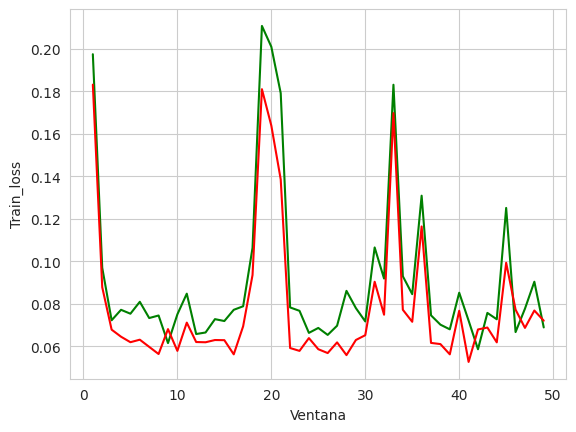

In [ ]:
import seaborn as sns

sns.lineplot(data=df_resultados, x='Ventana', y='Train_loss', color='green')
sns.lineplot(data=df_resultados, x='Ventana', y='Val_loss', color='red')
_=plt.show()

Analicemos los resultados para las mejores y peores ventanas

In [ ]:
mejor_ventana = int(df_resultados.sort_values(by='Val_loss', ascending=True).iloc[0].Ventana)
peor_ventana = int(df_resultados.sort_values(by='Val_loss', ascending=False).iloc[0].Ventana)

In [ ]:
mejor_ventana

41

In [ ]:
peor_ventana

1

Proceso completo para ventana de 41 pasos


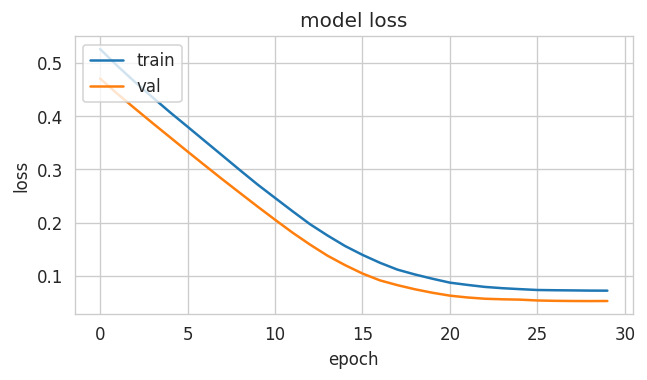

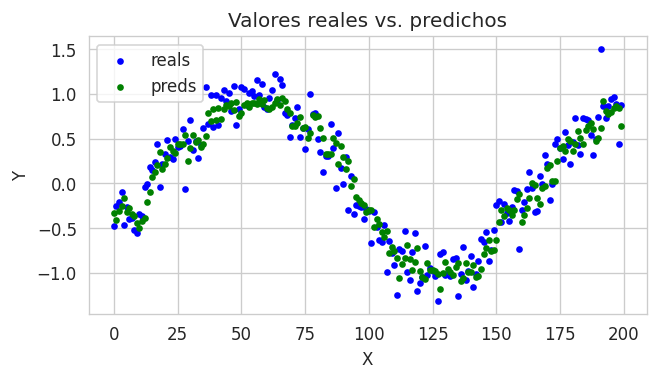

(41, 0.07208288684487343, 0.05262939810752869)

In [ ]:
proceso_completo(numPuntos=200, ventanaPasado=mejor_ventana, showPlots=True)

Proceso completo para ventana de 1 pasos


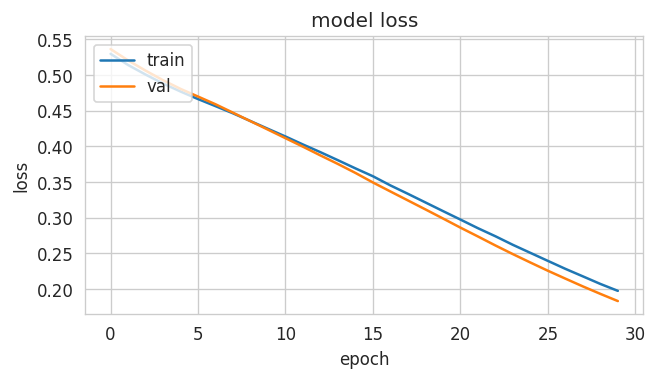

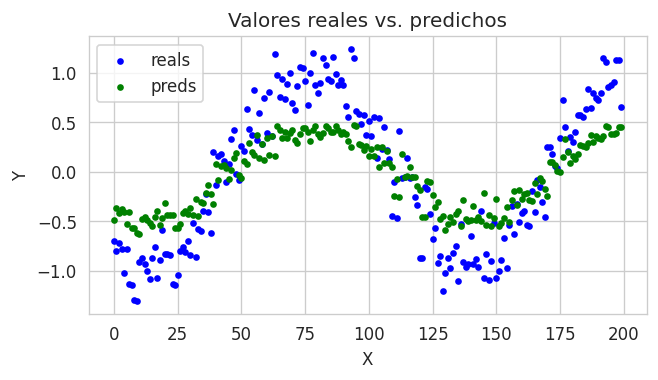

(1, 0.1974893641471863, 0.183172345161438)

In [ ]:
proceso_completo(numPuntos=200, ventanaPasado=peor_ventana, showPlots=True)